In [ ]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import warnings

warnings.filterwarnings("ignore")

In [ ]:
pedpy_blue = (89 / 255, 178 / 255, 216 / 255)
pedpy_orange = (220 / 255, 160 / 255, 73 / 255)
pedpy_green = (108 / 255, 190 / 255, 167 / 255)
pedpy_petrol = (98 / 255, 190 / 255, 190 / 255)
pedpy_grey = (114 / 255, 125 / 255, 139 / 255)
pedpy_red = (233 / 255, 117 / 255, 134 / 255)

# User Guide

This user guide will showcase the capabilities of *PedPy*. 
By following this guide you will learn how to set up your analysis and compute different metrics from the movement data.


This is a bottleneck experiment conducted at the University of Wuppertal in 2018.
You can see the basic setup of the experiment in the picture below:

```{eval-rst}
.. figure:: demo-data/bottleneck/040_c_56_h-.png
    :width: 400px
    :align: center
```

The data for this experiment is available {download}`here <demo-data/bottleneck/040_c_56_h-.txt>`, which belongs to this [experimental series](https://doi.org/10.34735/ped.2018.1) and is part of the publication [\"Crowds in front of bottlenecks at entrances from the perspective of physics and social psychology\"](https://doi.org/10.1098/rsif.2019.0871).

## Analysis set up

### Walkable area

In the beginning we will define the walkable area in which the pedestrian can move. 
For the used bottleneck experiment was conducted in the following set up:


```{eval-rst}
.. figure:: demo-data/bottleneck/experimental_setup.png
    :width: 50 %
    :align: center
```

The run handled in this user guide had a bottleneck width of 0.5m and w=5.6m.

Below is the code for creating such a walkable area:

In [ ]:
from pedpy import WalkableArea

walkable_area = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-0.7, -1.1),
            (-0.25, -1.1),
            (-0.25, -0.15),
            (-0.4, 0.0),
            (-2.8, 0.0),
            (-2.8, 6.7),
            (-3.05, 6.7),
            (-3.05, -0.3),
            (-0.7, -0.3),
            (-0.7, -1.0),
        ],
        # right barrier
        [
            (0.25, -1.1),
            (0.7, -1.1),
            (0.7, -0.3),
            (3.05, -0.3),
            (3.05, 6.7),
            (2.8, 6.7),
            (2.8, 0.0),
            (0.4, 0.0),
            (0.25, -0.15),
            (0.25, -1.1),
        ],
    ],
)

In [ ]:
from pedpy import plot_walkable_area

plot_walkable_area(
    walkable_area=walkable_area, hole_color="lightgrey"
).set_aspect("equal")

### Prepare measurement details

After we defined where the pedestrians can move, we now need to define in which regions we want to analyze in more details. 
This regions can either be a specific line, an area, or the whole walkable area.

In case of this bottleneck the most interesting area is a little bit in front of the bottlenck (here 0.5m) and the line at the beginning of the bottleneck.
The area is slightly in front of the bottleneck as here the highest density occur. 
In *PedPy* such areas are called **MeasurementAreas** and the lines **MeasurementLines**.
Below you can see how to define these:

In [ ]:
from pedpy import MeasurementArea, MeasurementLine

measurement_area = MeasurementArea(
    [(-0.4, 0.5), (0.4, 0.5), (0.4, 1.3), (-0.4, 1.3)]
)

measurement_line = MeasurementLine([(0.4, 0), (-0.4, 0)])

The corresponding measurement setup looks like:

In [ ]:
from pedpy import plot_measurement_setup

ax = plot_measurement_setup(
    walkable_area=walkable_area,
    hole_color="lightgrey",
    measurement_lines=[measurement_line],
    ml_color="r",
    ml_width=2,
    measurement_areas=[measurement_area],
    ma_color="r",
    ma_line_color="r",
    ma_line_width=1,
    ma_alpha=0.2,
).set_aspect("equal")

### Importing pedestrian movement data

The pedestrian movement data in *PedPy* is called trajectory data.

*PedPy* works with {class}`trajectory data <pedpy.data.trajectory_data.TrajectoryData>` which can be created from an import function for specific data files alternatively from a {class}`pandas.DataFrame` with the following columns:

- "id": unique numeric identifier for each person
- "frame": index of video frame where the positions were extracted
- "x", "y": position of the person (in meter) 

#### Loading from trajectory files

!!!!!TODO merge this two lines
*Pedpy* can load trajectories, if they are stored as the trajectory data provided in the [Jülich Data Archive](https://ped.fz-juelich.de/da/doku.php) directly.
*Pedpy* can load trajectories directly from text files, when:

- values are separated by any whitespace, e.g., space, tab
- file has at least 4 columns in the following order: "if", "frame", "x", "y"
- file may contain comment lines with `#` at in the beginning

For meaningful analysis (and loading of the trajectory file) you also need
- unit of the trajectory (m or cm)
- frame rate

For recent trajectory they are encoded in the header of the file, for older you may need to lead the documentation and provide the information in the loading process!

**Examples:**
With frame rate, but no unit
```
# description: UNI_CORR_500_01
# framerate: 25.00
#geometry: geometry.xml

# PersID	Frame	X	Y	Z
1	98	4.6012	1.8909	1.7600
1	99	4.5359	1.8976	1.7600
1	100	4.4470	1.9304	1.7600
...
```

No header at all:
```
1 27 164.834 780.844 168.937
1 28 164.835 771.893 168.937
1 29 163.736 762.665 168.937
1 30 161.967 753.088 168.937
...
```

If your data is structured in a different way please take a look at the next section.
Since the data we want to analyze is from the data archive, we can directly load the trajectory data with *PedPy*:  

In [ ]:
from pedpy import load_trajectory, TrajectoryUnit

traj = load_trajectory(
    trajectory_file=pathlib.Path("demo-data/bottleneck/040_c_56_h-.txt"),
    default_unit=TrajectoryUnit.METER,  # needs to be provided as it not defined in the file
    # default_frame_rate=25., # can be ignored here as the frame rate is defined in the file
)

The loaded trajectory data look like:

In [ ]:
from pedpy import plot_trajectories

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
plot_trajectories(traj=traj, traj_color=pedpy_blue)
plt.show()

#### Loading from Pandas DataFrame

To construct the  {class}`trajectory data <pedpy.data.trajectory_data.TrajectoryData>` from a **DataFrame** you also need to provide the frame rate at which the data was recorded.
If you have both the construction of the {class}`trajectory data <pedpy.data.trajectory_data.TrajectoryData>` can be done with:


In [ ]:
from pedpy import TrajectoryData

data = pd.DataFrame(
    [[0, 1, 0, 0]],
    columns=["id", "frame", "x", "y"],
)
trajectory_data = TrajectoryData(data=data, frame_rate=25.0)

Alternatively, the data can be also loaded from any file format that is supported by **Pandas**.


### Plot setup

For a better overview of our created measurement setup, see the plot below:

In [ ]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area,
    measurement_areas=[measurement_area],
    measurement_lines=[
        measurement_line,
    ],
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ml_color="r",
    ml_width=1,
    ma_color="r",
    ma_alpha=0.1,
    ma_line_color="r",
    ma_line_width=1,
    ax=ax,
)
plt.show()

### Validate that trajectory is completely inside the walkable area.

An important step before starting the analysis is to verify that all trajectories lie within the constructed walkable area.
Otherwise you might get errors.
*PedPy* provides a function to **test your trajectories**, and offers also a function to get **all invalid trajectories**:

In [ ]:
from pedpy import is_trajectory_valid, get_invalid_trajectory

print(
    f"Trajectory is valid: {is_trajectory_valid(traj_data=traj, walkable_area=walkable_area)}"
)
get_invalid_trajectory(traj_data=traj, walkable_area=walkable_area)

**For demonstration purposes, wrongly place the obstacle s.th. some pedestrian walk through it!**

We now create a faulty geometry, s.th. you can see how the result would like.
Therefore, the right obstacle will be moved a bit towards the center of the bottlneck:

In [ ]:
from pedpy import WalkableArea

walkable_area_faulty = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-0.7, -1.1),
            (-0.25, -1.1),
            (-0.25, -0.15),
            (-0.4, 0.0),
            (-2.8, 0.0),
            (-2.8, 6.7),
            (-3.05, 6.7),
            (-3.05, -0.3),
            (-0.7, -0.3),
            (-0.7, -1.0),
        ],
        # right barrier is too close to the middle
        [
            (0.15, -1.1),
            (0.6, -1.1),
            (0.6, -0.3),
            (3.05, -0.3),
            (3.05, 6.7),
            (2.8, 6.7),
            (2.8, 0.0),
            (0.3, 0.0),
            (0.15, -0.15),
            (0.15, -1.1),
        ],
    ],
)

In [ ]:
from pedpy import plot_measurement_setup, plot_walkable_area

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

ax = plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area_faulty,
    traj_color=pedpy_blue,
    traj_alpha=0.5,
    traj_width=1,
    hole_color="lightgrey",
    ax=ax,
)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
plt.show()

If you get any invalid trajectories, you should check whether you constructed your walkable area correctly.
In some cases you will get such errors when you have head trajectories, and the pedestrian lean over the obstacles.
Then you need to prepare your data before you can start your analysis.

In [ ]:
from pedpy import is_trajectory_valid, get_invalid_trajectory

print(
    f"Trajectory is valid: {is_trajectory_valid(traj_data=traj, walkable_area=walkable_area_faulty)}"
)
get_invalid_trajectory(traj_data=traj, walkable_area=walkable_area_faulty)

## Analysis

Now that we set up the analysis environment, we can start with the real analysis.
*PedPy* provides different methods to obtain multiple metric from the trajectory data:

- Density
- Speed
- Flow
- Neighborhood
- Distance/Time to entrance
- Profiles

### Density

Density is a fundamental metric in pedestrian dynamics.
As it indicated how much space is accessible to each pedestrian within a specific area.
High density can lead to reduced walking speeds, increased congestion, and even potential safety hazards.

#### Classic density

The classic approach to calculate the density is to count the number of pedestrians ($N$) inside a specific space ($M$) and divide it by the area of that space ($A(M)$).

$$
\rho_{classic} = {N \over A(M)}
$$

In *PedPy* this can be computed with:


In [ ]:
from pedpy import compute_classic_density

classic_density = compute_classic_density(
    traj_data=traj, measurement_area=measurement_area
)

The resulting time-series can be seen below:

In [ ]:
fig = plt.figure()
plt.title("Classic density")
plt.plot(
    classic_density.index,
    classic_density.values,
    lw=2,
    linestyle="-",
    color=pedpy_blue,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.grid()
plt.show()

#### Voronoi density

Another approach for calculating the density is to compute the **Voronoi tesselation** of the pedestrians positions at a given time, the resulting Voronoi polygons ($V$) directly relate to the individual's density.
For a pedestrian $i$ the individual density is defined as:

$$
\rho_i = {1 \over A(V_i)}
$$


##### Compute individual Voronoi Polygons

The first step for computing the Voronoi density, is to compute the individual's Voronoi polygon.
As these polygons may become infinite for pedestrians at the edge of the crowd, these polygons are restricted by the **walkable area**.
This cutting at the boundaries can lead to split Voronoi polygons. For each of the split polygons it is checked, in which the pedestrian is located. 
This polygon then is assigned.

:::{important}
As these Voronoi polygons work on the Euclidean distance, some unexpected artifacts may occur on non-convex walkable areas. Please keep that in mind! How that may look like, you can see in the plots later in this guide.
:::

###### Without cut-off

The computation of the individual polygons can be done from the **trajectory data** and **walkable area** with:

In [ ]:
from pedpy import compute_individual_voronoi_polygons

individual = compute_individual_voronoi_polygons(
    traj_data=traj, walkable_area=walkable_area
)

###### With cut-off

When having a large **walkable area** or widely spread pedestrians the Voronoi polygons may become quite large.
In *PedPy* it is possible the restrict the size of the computed Polygons.
This can be done by defining a **cut off**, which is essentially an approximated circle which gives the maximum extension of a single Voronoi polygon.
For the creation of the **cut off**, we need to define how accurate we want to approximate the circle, the differences can be seen below:

```{eval-rst}
.. figure:: images/voronoi_cutoff_differences.png
    :align: center
```

Now, with that **cut off** the computation of the individual polygons becomes:

In [ ]:
from pedpy import compute_individual_voronoi_polygons, Cutoff

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=1.0, quad_segments=3),
)

###### Comparison

To get an better impression what the differences between the Voronoi polygons with and without the **cut off** are, take a look at the plot below:

In [ ]:
from pedpy.column_identifier import ID_COL, FRAME_COL
from pedpy import plot_voronoi_cells
import matplotlib as mpl
import matplotlib.pyplot as plt

frame = 600

fig = plt.figure(f"frame = {frame}")
fig.suptitle(f"frame = {frame}")
df_frame = individual[individual.frame == frame]
df_frame = pd.merge(traj.data, df_frame, on=[ID_COL, FRAME_COL])

ax1 = fig.add_subplot(121, aspect="equal")
ax1.set_title("w/o cutoff")
plot_voronoi_cells(
    data=df_frame,
    walkable_area=walkable_area,
    color_mode="density",
    show_ped_positions=True,
    ped_size=4,
    ax=ax1,
    show_colorbar=False,
    hole_color="lightgrey",
)

df_frame_cutoff = individual_cutoff[individual_cutoff.frame == frame]
df_frame_cutoff = pd.merge(traj.data, df_frame_cutoff, on=[ID_COL, FRAME_COL])

ax2 = fig.add_subplot(122, aspect="equal")
ax2.set_title("w cutoff")

plot_voronoi_cells(
    data=df_frame_cutoff,
    walkable_area=walkable_area,
    color_mode="density",
    show_ped_positions=True,
    ped_size=4,
    ax=ax2,
    show_colorbar=False,
    hole_color="lightgrey",
)
cbar_ax = fig.add_axes([0.1, -0.05, 0.88, 0.05])

norm = mpl.colors.Normalize(vmin=0, vmax=10)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet"), norm=norm)
sm.set_array([])
plt.colorbar(
    sm,
    cax=cbar_ax,
    shrink=0.1,
    label="$\\rho$ \ 1/$m^2$",
    aspect=2,
    orientation="horizontal",
)
fig.tight_layout()
plt.show()

##### Compute actual Voronoi density

From these individual data we can now compute the Voronoi density in the known measurement area ($M$):

$$
    \rho_{voronoi} = { TODO \over A(M)} 
$$

###### Without cut-off

First, we compute the Voronoi density in the **measurement area** without a **cut-off**:

In [ ]:
from pedpy import compute_voronoi_density

density_voronoi, intersecting = compute_voronoi_density(
    individual_voronoi_data=individual, measurement_area=measurement_area
)

In [ ]:
fig = plt.figure()
plt.title("Voronoi density")
plt.plot(
    density_voronoi.index,
    density_voronoi.values,
    lw=2,
    linestyle="-",
    color=pedpy_orange,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.grid()
plt.show()

###### With cut-off

Second, we compute it now from the individual **cut-off** Voronoi polygons:


In [ ]:
from pedpy import compute_voronoi_density

density_voronoi_cutoff, intersecting_cutoff = compute_voronoi_density(
    individual_voronoi_data=individual_cutoff, measurement_area=measurement_area
)

In [ ]:
fig = plt.figure()
plt.title("Voronoi density with cut-off")
plt.plot(
    density_voronoi_cutoff.index,
    density_voronoi_cutoff.values,
    lw=2,
    linestyle="-",
    color=pedpy_grey,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.grid()
plt.show()

#### Comparison

Now we have obtained the mean density inside the measurement area with different methods.
To compare the results take a look at the following plot:

In [ ]:
fig = plt.figure()
plt.title("Comparison of different density methods")
plt.plot(
    classic_density.reset_index().frame,
    classic_density.values,
    label="classic",
    color=pedpy_blue,
)
plt.plot(
    density_voronoi.reset_index().frame,
    density_voronoi,
    label="voronoi",
    color=pedpy_orange,
)
plt.plot(
    density_voronoi_cutoff.reset_index().frame,
    density_voronoi_cutoff,
    label="voronoi with cutoff",
    color=pedpy_grey,
)
plt.xlabel("frame")
plt.ylabel("$\\rho$ / 1/$m^2$")
plt.grid()
plt.legend()
plt.show()

#### Passing density (individual)

Another option to compute the individual density, is the **passing density**. 
For the computation it needs a **measurement line** and the distance to a second "virtual" **measurement line** which form a "virtual" **measurement area** ($M$).

In this our example, we want to measure from the entrance of the bottleneck (top line) 1m towards the exit of the bottleneck (bottom line).
The set set up is shown below:

In [ ]:
from pedpy import compute_frame_range_in_area

frames_in_area, used_area = compute_frame_range_in_area(
    traj_data=traj, measurement_line=measurement_line, width=1.0
)

In [ ]:
plt.figure()
ax = plot_measurement_setup(
    measurement_areas=[used_area],
    measurement_lines=[
        measurement_line,
        MeasurementLine(shapely.offset_curve(measurement_line.line, 1.0)),
    ],
    ml_color="r",
    ml_width=2,
    ma_color="r",
    ma_line_color="r",
    ma_line_width=0,
    ma_alpha=0.2,
    walkable_area=walkable_area,
    hole_color="lightgrey",
)
ax.set_aspect("equal")
plt.show()

For each pedestrian the frame range ($[t_{in}, t_{out}]$) in which they are inside this area is computed and counted how many pedestrian are inside the area for each frame ($N(t)$). 
The average number of pedestrians in that frame range, then is the passing density:

$$
    \rho_{passing} = {1 \over {t_{out}-t_{in}}} \int^{t_{out}}_{t_{in}} {{N(t)} \over A(M)} dt
$$

:::{important}
It is only possible
:::

Here, we want to compute the passing density inside the bottleneck, this can be done with:


In [ ]:
from pedpy import compute_passing_density
from pedpy import compute_frame_range_in_area

frames_in_area, used_area = compute_frame_range_in_area(
    traj_data=traj, measurement_line=measurement_line, width=1.0
)
passing_density = compute_passing_density(
    density_per_frame=classic_density, frames=frames_in_area
)

This gives for each pedestrian one value for the density. 
The following plot shows how the individual density inside is distributed the bottleneck:

In [ ]:
plt.figure()
plt.title("Individual density inside bottleneck")
violin_parts = plt.violinplot(
    passing_density.density, showmeans=True, showextrema=True, showmedians=True
)
for pc in violin_parts["bodies"]:
    pc.set_facecolor(pedpy_blue)
    pc.set_edgecolor("k")
plt.xlabel("")
plt.ylabel("$\\rho$ / 1/$m^2$")
plt.xticks([])
plt.show()

### Speed

A further important measure in pedestrian dynamics is the speed of the pedestrians.
Low speeds can indicate congestions or other obstructions in the flow of the crowd.

#### Individual speed

For computing the individuals speed at a specific frame $v_i(t)$ a specific frame step ($n$) is needed.
From the positions $n$ frames in the future and the past, the positions are taken: $X_{future}$, $X_{past}$.

TODO $\Delta t$

The distance between these position then is used to compute the speed with:

$$
v_i(t) = {|{X_{future} - X_{past}|}\over{\Delta t}}
$$

```{eval-rst}
.. image:: images/speed_both.svg
    :align: center
    :width: 80 %
```

When getting closer to the start, or end of the trajectory data, it is not possible to use the full range of the frame interval for computing the speed.
For these cases *PedPy* offers three different methods to compute the speed:

1. exclude these parts
2. adaptively shrink the window in which the speed is computed
3. switch to one-sided window

##### Exclude border

When not enough frames available to compute the speed at the borders, for these parts no speed can be computed and they are ignored.


In [105]:
from pedpy import compute_individual_speed, SpeedCalculation

individual_speed_exclude = compute_individual_speed(
    traj_data=traj,
    frame_step=15,
    compute_velocity=True,
    speed_calculation=SpeedCalculation.BORDER_EXCLUDE
)

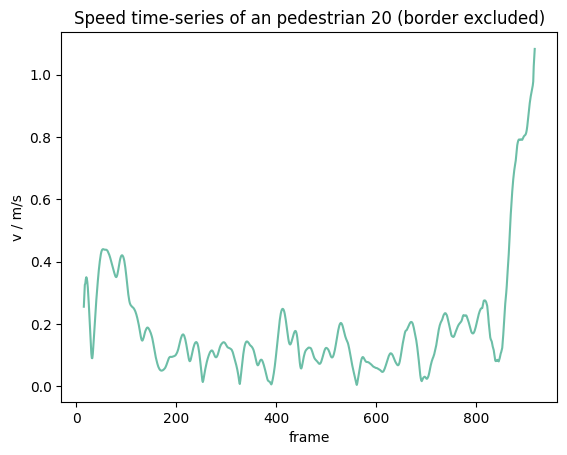

In [106]:
ped_id = 20
plt.figure()
plt.title(f"Speed time-series of an pedestrian {ped_id} (border excluded)")
single_individual_speed = individual_speed_exclude[individual_speed_exclude.id == ped_id]
plt.plot(
    single_individual_speed.frame,
    single_individual_speed.speed,
    color=pedpy_green,
)

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

##### Adaptive border window

When using the adaptive approach
```{eval-rst}
.. image:: images/speed_border_adaptive_future.svg
    :width: 46 %
.. image:: images/speed_border_adaptive_past.svg
    :width: 46 %
```

TODO example code



In [107]:
from pedpy import compute_individual_speed, SpeedCalculation

individual_speed_adaptive = compute_individual_speed(
    traj_data=traj,
    frame_step=15,
    compute_velocity=True,
    speed_calculation=SpeedCalculation.BORDER_ADAPTIVE
)

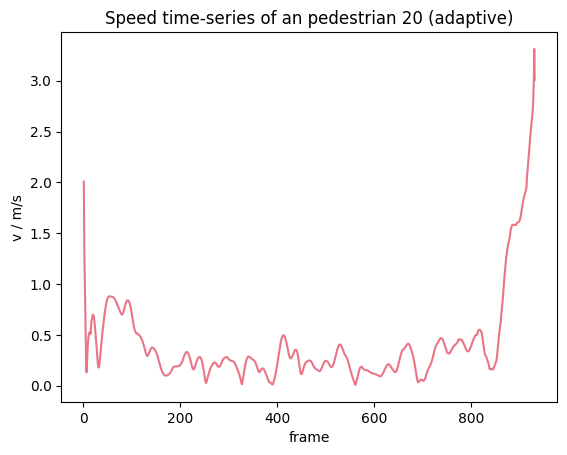

In [108]:
ped_id = 20
plt.figure()
plt.title(f"Speed time-series of an pedestrian {ped_id} (adaptive)")
single_individual_speed = individual_speed_adaptive[individual_speed_adaptive.id == ped_id]
plt.plot(
    single_individual_speed.frame,
    single_individual_speed.speed,
    color=pedpy_red,
)

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

##### Single sided border window

In these cases, one of the end points to compute the movement becomes the current position $X_{current}$.
When getting to close to the start of the trajectory, the movement is computed from $X_{current}$ to $X_{future}$.
In the other case the movement is from $X_{past}$ to $X_{current}$.

$$
    v_i(t) = {|{X_{future} - X_{current}|}\over{ \frac{1}{2} \Delta t}} \text{, or } v_i(t) = {|{X_{current} - X_{past}|}\over{ \frac{1}{2} \Delta t}}
$$

```{eval-rst}
.. image:: images/speed_border_single_sided_future.svg
    :width: 46 %
.. image:: images/speed_border_single_sided_past.svg
    :width: 46 %
```

:::{important}
As at the edges of the trajectories the time interval gets halved, there may occur some jumps computed speeds.
:::

TODO example code


In [109]:
from pedpy import compute_individual_speed, SpeedCalculation

individual_speed_single_sided = compute_individual_speed(
    traj_data=traj,
    frame_step=15,
    compute_velocity=True,
    speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED
)

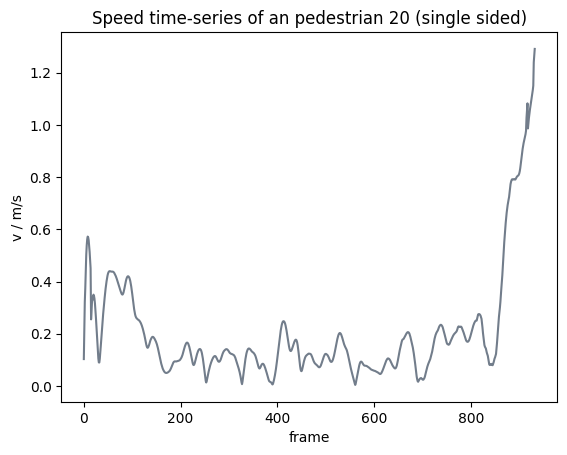

In [110]:
ped_id = 20
plt.figure()
plt.title(f"Speed time-series of an pedestrian {ped_id} (single sided)")
single_individual_speed = individual_speed_single_sided[individual_speed_single_sided.id == ped_id]
plt.plot(
    single_individual_speed.frame,
    single_individual_speed.speed,
    color=pedpy_grey,
)

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

##### Comparison

To demonstrate the differences in the computed speeds, take a look at the following plot:


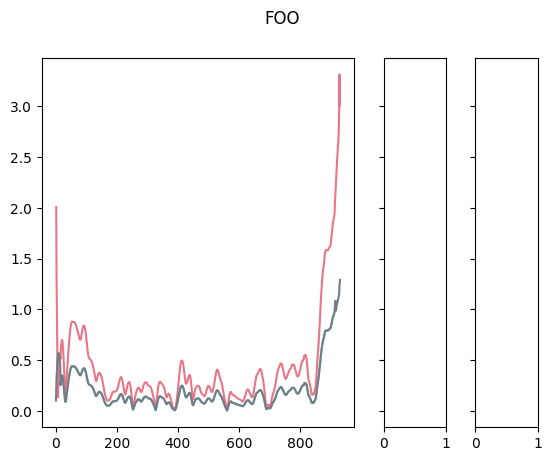

In [114]:
ped_id = 20

fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [5, 1, 1]}, sharey=True)

fig.suptitle("FOO")
speed_exclude = individual_speed_exclude[individual_speed_exclude.id == ped_id]
speed_adaptive = individual_speed_adaptive[individual_speed_adaptive.id == ped_id]
speed_single_sided = individual_speed_single_sided[individual_speed_single_sided.id == ped_id]

ax[0].plot(
    speed_exclude.frame,
    speed_exclude.speed,
    color=pedpy_green,
)
ax[0].plot(
    speed_adaptive.frame,
    speed_adaptive.speed,
    color=pedpy_red,
)
ax[0].plot(
    speed_single_sided.frame,
    speed_single_sided.speed,
    color=pedpy_grey,
)
plt.show()

##### Individual speed in specific movement direction


It is also possible to compute the individual speed in a specific direction...

:::{important}
When using a specific direction, the computed speed may become negative!
:::

TODO image


In [ ]:
individual_speed_direction = compute_individual_speed(
    traj_data=traj,
    frame_step=5,
    movement_direction=np.array([0, -1]),
    compute_velocity=True,
    speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED
)

In [ ]:
fig = plt.figure()
plt.title(
    "Velocity time-series of an excerpt of the pedestrians in a specific direction"
)
for color, ped_id in zip(colors, ped_ids):
    single_individual_speed = individual_speed_direction[
        individual_speed_direction.id == ped_id
    ]
    plt.plot(
        single_individual_speed.frame,
        single_individual_speed.speed,
        color=color,
    )

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

#### Mean speed

Now, that we have computed the individual's speed, we want to compute the mean speed in the already used measurement area $M$ closely in front of the bottleneck.
The mean speed $v_{mean}$ is defined as
$$
    v_{mean}(t) = {{1} \over {N}} \sum_{i \in P_M} v_i(t), 
$$
where $P_M$ are all pedestrians inside the measurement area, and $N$ the number of pedestrians inside the measurement area ($|P_M|$).

This can be as follows with *PedPy*:
 

In [ ]:
from pedpy import compute_mean_speed_per_frame

mean_speed = compute_mean_speed_per_frame(
    traj_data=traj,
    measurement_area=measurement_area,
    individual_speed=individual_speed,
)

In [ ]:
fig = plt.figure()
plt.title("Mean speed in front of the bottleneck")
plt.plot(mean_speed.index, mean_speed, color=pedpy_blue)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

The same can be now computed, using the speed in a movement direction as basis:

In [ ]:
mean_speed_direction = compute_mean_speed_per_frame(
    traj_data=traj,
    measurement_area=measurement_area,
    individual_speed=individual_speed_direction,
)

In [ ]:
plt.figure()
plt.title("Mean speed in specific direction in front of the bottleneck")
plt.plot(mean_speed_direction.index, mean_speed_direction, color=pedpy_red)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

#### Voronoi speed

A further approach to compute average speed $v_{voronoi}(t)$ in an area by weighting the individuals speed by the size of their corresponding Voronoi polygon $V_i$ inside the measurement area $M$.

$$
    v_{voronoi}(t) = TODO
$$

This can be done in *PedPy* with:

In [ ]:
from pedpy import compute_voronoi_speed

voronoi_speed = compute_voronoi_speed(
    traj_data=traj,
    individual_voronoi_intersection=intersecting,
    individual_speed=individual_speed,
    measurement_area=measurement_area,
)

In [ ]:
plt.figure()
plt.title("Voronoi speed in front of the bottleneck")
plt.plot(voronoi_speed.index, voronoi_speed, color=pedpy_orange)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

Analogously, this can be done with the speed in a specific direction with:

In [ ]:
voronoi_speed_direction = compute_voronoi_speed(
    traj_data=traj,
    individual_voronoi_intersection=intersecting,
    individual_speed=individual_speed_direction,
    measurement_area=measurement_area,
)

In [ ]:
plt.figure()
plt.title("Voronoi velocity in specific direction in front of the bottleneck")
plt.plot(
    voronoi_speed_direction.index,
    voronoi_speed_direction,
    color=pedpy_grey,
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

#### Comparison mean speed vs Voronoi speed

We now computed the speed with different methods, this plot shows what the different results look like compared to each other:

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Comparison of different velocity methods")
plt.plot(
    voronoi_speed.reset_index().frame,
    voronoi_speed,
    label="Voronoi",
    color=pedpy_orange,
)
plt.plot(
    voronoi_speed_direction.reset_index().frame,
    voronoi_speed_direction,
    label="Voronoi direction",
    color=pedpy_grey,
)
plt.plot(
    mean_speed.reset_index().frame,
    mean_speed,
    label="classic",
    color=pedpy_blue,
)
plt.plot(
    mean_speed_direction.reset_index().frame,
    mean_speed_direction,
    label="classic direction",
    color=pedpy_red,
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

#### Passing speed (individual)

With the same principles as described in  **link to section passing density**, the individual speeds $v^i_{passing}$ is defined as
$$
    v^i_{passing} = {{d}\over{t_{out}-t_{in}},
$$
where $d$ is the distance between the two measurement lines.

In *PedPy* this can be done with: 

In [ ]:
from pedpy import compute_passing_speed
from pedpy import compute_frame_range_in_area

passing_offset = 1.0
frames_in_area, _ = compute_frame_range_in_area(
    traj_data=traj, measurement_line=measurement_line, width=passing_offset
)
passing_speed = compute_passing_speed(
    frames_in_area=frames_in_area,
    frame_rate=traj.frame_rate,
    distance=passing_offset,
)

In [ ]:
plt.figure()
plt.title("Individual speed in bottleneck")
violin_parts = plt.violinplot(
    passing_speed.speed, showmeans=True, showextrema=True, showmedians=True
)
for pc in violin_parts["bodies"]:
    pc.set_facecolor(pedpy_blue)
    pc.set_edgecolor("k")
plt.xlabel("")
plt.ylabel("v / m/s")
plt.xticks([])
plt.show()

### Flow

Add some text

#### N-t diagram at bottleneck

In [ ]:
from pedpy import compute_n_t

nt, crossing = compute_n_t(
    traj_data=traj,
    measurement_line=measurement_line,
)

In [ ]:
from pedpy.column_identifier import TIME_COL, CUMULATED_COL

plt.figure()
plt.title("N-t at bottleneck")
plt.plot(nt[TIME_COL], nt[CUMULATED_COL], color=pedpy_blue)
plt.xlabel("t / s")
plt.ylabel("Cumulative pedestrians")
plt.show()

#### Flow at bottleneck

The flow at the bottleneck ...

Frame intervals

```{eval-rst}
.. image:: images/flow.svg
    :align: center
    :width: 80 %
```

The flow then ...

```{eval-rst}
.. image:: images/flow_zoom.svg
    :align: center
    :width: 60 %
```

The flow:

$$
    J = {{N^{\Delta t}} \over {t^{\Delta t}_N - t^{\Delta t}_1}}
$$

At the same time also the mean speed

$$
    v_{crossing} = {1 \over N^{\Delta t} } \sum^{N^{\Delta t}}_{i=1} v_i(t)
$$

To compute the flow and mean speed when passing the line with *PedPy* use:

In [ ]:
from pedpy import compute_flow

delta_frame = 100
flow = compute_flow(
    nt=nt,
    crossing_frames=crossing,
    individual_speed=individual_speed,
    delta_frame=delta_frame,
    frame_rate=traj.frame_rate,
)

In [ ]:
from pedpy.column_identifier import FLOW_COL, MEAN_SPEED_COL

plt.figure()
plt.title("Crossing velocities at the corresponding flow at bottleneck")
plt.scatter(flow[FLOW_COL], flow[MEAN_SPEED_COL], color=pedpy_blue)
plt.xlabel("J / 1/s")
plt.ylabel("v / m/s")
plt.show()

### Neighborhood

To analyze, which pedestrians are close to each other, it is possible to compute the neighbors of each pedestrian.
We define two pedestrians as neighbors if their Voronoi polygons ($V_i$, $V_j$) touch at some point, in case of *PedPy* they are touching if their distance is below 1mm.
As basis for the computation one can either use the uncut or cut Voronoi polygons.
When using the uncut Voronoi polygons, pedestrian may be detected as neighbors even when their distance is quite large in low density situation.
Therefor, it is recommended to use the cut Voronoi polygons, where the cut-off radius can be used to define a maximal distance between neighboring pedestrians.

To compute the neighbors in *PedPy* use:

In [ ]:
from pedpy import compute_neighbors

neighbors = compute_neighbors(individual_cutoff)

In [ ]:
from pedpy.column_identifier import POLYGON_COL

frame = 350

voronoi_neighbors = pd.merge(
    individual_cutoff[individual_cutoff.frame == frame],
    neighbors[neighbors.frame == frame],
    on=[ID_COL, FRAME_COL],
)
used_neighbors = voronoi_neighbors[ID_COL].values[4:6]


fig, axes = plt.subplots(nrows=1, ncols=len(used_neighbors))
fig.suptitle(f"Neighbors of a single pedestrian")

for base, ax in zip(used_neighbors, axes):
    base_neighbors = voronoi_neighbors[voronoi_neighbors[ID_COL] == base][
        "neighbors"
    ].values[0]
    ax.set_title(f"id = {base}")

    plot_walkable_area(
        ax=ax, walkable_area=walkable_area, hole_color="lightgrey"
    )

    for _, row in voronoi_neighbors.iterrows():
        poly = row[POLYGON_COL]
        ped_id = row[ID_COL]

        are_neighbors = ped_id in base_neighbors

        color = pedpy_grey
        alpha = 0.2
        if ped_id == base:
            color = pedpy_orange
            alpha = 0.5

        if are_neighbors:
            color = pedpy_green
            alpha = 0.5

        ax.plot(*poly.exterior.xy, alpha=1, color=color)
        ax.fill(*poly.exterior.xy, alpha=alpha, color=color)
        ax.set_aspect("equal")
    fig.tight_layout()
plt.show()

### Distance to entrance/Time to entrance

An indicator to detect congestions or jams in trajectory data are distance/time to crossing.
It shows how much time until the crossing of the measurement line is left and how big the distance to that line is.

In *PedPy* this can be done with:

In [ ]:
from pedpy import compute_time_distance_line

df_time_distance = compute_time_distance_line(
    traj_data=traj, measurement_line=measurement_line
)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Distance to entrance/Time to entrance")
for ped_id, ped_data in df_time_distance.groupby(by=ID_COL):
    plt.plot(
        ped_data.distance,
        ped_data.time / traj.frame_rate,
        c="gray",
        alpha=0.7,
        lw=0.25,
    )
    min_data = ped_data[ped_data.frame == ped_data.frame.min()]
    plt.scatter(
        min_data.distance,
        min_data.time / traj.frame_rate,
        c="gray",
        s=5,
        marker="o",
    )

ax.grid()
ax.set_xlabel("distance to line / m")
ax.set_ylabel("time to line / s")

ax.set_xlim([0, None])
ax.set_ylim([0, None])
plt.show()

### Profiles

For the computation of the profiles the given {class}`~geometry.WalkableArea` is divided into square grid cells.
Each of these grid cells is then used as a {class}`~geometry.MeasurementArea`  to compute the Voronoi density as in {func}`~density_calculator.compute_voronoi_density`.

```{eval-rst}
.. image:: /images/profile_grid.svg
    :width: 70 %
    :align: center
```

The computation of the speed in each cell is either done with the Voronoi speed computation as in {func}`~speed_calculator.compute_voronoi_speed` when using {data}`~profile_calculator.SpeedMethod.VORONOI`. 
Or as in {func}`~speed_calculator.compute_mean_speed_per_frame` when using {data}`~profile_calculator.SpeedMethod.ARITHMETIC`.

```{eval-rst}
.. note::

    As this is a quite compute heavy operation, it is suggested to reduce the trajectories to the important areas and limit the input data to the most relevant frame interval.
```


In [ ]:
from pedpy import (
    compute_profiles,
    compute_individual_voronoi_polygons,
    compute_individual_speed,
    SpeedMethod,
)

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

individual_speed = compute_individual_speed(
    traj_data=traj,
    frame_step=5,
)

In [ ]:
min_frame_profiles = 250  # We use here just an excerpt of the
max_frame_profiles = 400  # trajectory data to reduce compute time

density_profiles, speed_profiles = compute_profiles(
    individual_voronoi_speed_data=pd.merge(
        individual_cutoff[
            individual_cutoff.frame.between(
                min_frame_profiles, max_frame_profiles
            )
        ],
        individual_speed[
            individual_speed.frame.between(
                min_frame_profiles, max_frame_profiles
            )
        ],
        on=[ID_COL, FRAME_COL],
    ),
    walkable_area=walkable_area.polygon,
    grid_size=0.25,
    speed_method=SpeedMethod.ARITHMETIC,
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bounds = walkable_area.bounds

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)

ax0.set_title("Density")
cm = ax0.imshow(
    np.mean(density_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="jet",
    vmin=0,
    vmax=10,
)
fig.colorbar(cm, ax=ax0, shrink=0.3, label="$\\rho$ / 1/$m^2$")
ax0.plot(*walkable_area.polygon.exterior.xy, color="w")
plot_walkable_area(walkable_area=walkable_area, ax=ax0, hole_color="w")

ax1.set_title("Speed")
cm = ax1.imshow(
    np.mean(speed_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    cmap="jet",
    vmin=0,
    vmax=2,
)
fig.colorbar(cm, ax=ax1, shrink=0.3, label="v / m/s")
plot_walkable_area(walkable_area=walkable_area, ax=ax1, hole_color="w")


fig.tight_layout()

## Preprocess the data

Until now, we used complete trajectories, but sometimes not all the data is relevant for the analysis. 
If the data comes from larger simulation or experiments you may be only interested in data close to your region of interest or data in a specific time range.
As *PedPy* builds up on **Pandas** as data container, the filtering methods from **Pandas** can also be used here.
More information on filtering and merging with Pandas can be found here: **pandas filtering merging**

### Geometric filtering

First, we want to filter the data by geometrical principles, therefor we combine the capabilities of **Pandas** and **Shapely**. 

#### Data inside Polygon

In the first case, we are only interested in trajectory data inside the known measurement area. 

In [ ]:
import shapely

bottleneck = shapely.Polygon([(0.25, 0), (0.25, -1), (-0.25, -1), (-0.25, 0)])
leaving_area = shapely.Polygon([(-3, -1), (-3, -2), (3, -2), (3, -1)])

In [ ]:
data_inside_ma = traj.data[shapely.within(traj.data.point, bottleneck)]

In [ ]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=TrajectoryData(data_inside_ma, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_areas=[MeasurementArea(bottleneck)],
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ml_color="r",
    ml_width=1,
    ma_color="r",
    ma_alpha=0.1,
    ma_line_color="r",
    ma_line_width=1,
    ax=ax,
)
ax.set_xlim([-0.75, 0.75])
ax.set_ylim([-1.5, 0.5])
plt.show()

#### Data outside Polygon

Secondly, we want to filter the data, such that the result contains only data which is outside a given area. 
In our case we want to remove all data behind the bottleneck, here called leaving area:

In [ ]:
data_outside_leaving_area = traj.data[
    ~shapely.within(traj.data.point, leaving_area)
]

In [ ]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

ax = plot_measurement_setup(
    traj=TrajectoryData(data_outside_leaving_area, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_areas=[MeasurementArea(leaving_area)],
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ml_color="r",
    ml_width=1,
    ma_color="r",
    ma_alpha=0.1,
    ma_line_color="r",
    ma_line_width=1,
    ax=ax,
)
plt.show()

#### Data close to line

It is not only possible to check whether a point is within a given polygon, it is also possible to check if the distance to a given geometrical object is below a given threshold.
Here we want all the data that is within 1m of the measurement line at the entrance of the bottleneck: 

In [ ]:
data_close_ma = traj.data[
    shapely.dwithin(traj.data.point, measurement_line.line, 1)
]

In [ ]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=TrajectoryData(data_close_ma, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_lines=[measurement_line],
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ml_color="r",
    ml_width=1,
    ma_color="r",
    ma_alpha=0.1,
    ma_line_color="r",
    ma_line_width=1,
    ax=ax,
)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-2.5, 1.5])
plt.show()

### Time based filtering

It is not only possible to filter the data by geometrical means, but also depending on time information.
In experiments, you might only be interested in steady state data, this can be also be achieved by utilizing the **Pandas** filtering methods: 

In [ ]:
data_frame_range = traj.data[
    traj.data.frame.between(300, 600, inclusive="both")
]

In [ ]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=TrajectoryData(data_frame_range, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ax=ax,
)
plt.show()

### ID based filtering

It is also possible to filter the data in a way that only specific pedestrians are contained:

In [ ]:
data_id = traj.data[traj.data.id == 20]

In [ ]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=TrajectoryData(data_id, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ax=ax,
)
plt.show()

It is also possible to filter for multiple ids:

In [ ]:
ids = [10, 20, 30, 40]
data_id = traj.data[traj.data.id.isin(ids)]

In [ ]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=TrajectoryData(data_id, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ax=ax,
)
plt.show()

## What to do with the results?

Now we have completed our analysis, what can be done to 

- combine for further analysis
- save results

### Combine multiple DataFrames

From the analysis we have one **DataFrame** containing the trajectory data:

In [ ]:
traj.data

and one containing the individual Voronoi data:

In [ ]:
individual

As both have the columns 'id' and 'frame' in common, these can be used to merge the dataframes.
See **pandas.merge** for more information on how **DataFrame**s can be merged.

In [ ]:
data_with_voronoi_cells = traj.data.merge(intersecting, on=[ID_COL, FRAME_COL])
data_with_voronoi_cells

In [ ]:
from pedpy.column_identifier import SPEED_COL

data_with_voronoi_cells_speed = data_with_voronoi_cells.merge(
    individual_speed[[ID_COL, FRAME_COL, SPEED_COL]], on=[ID_COL, FRAME_COL]
)
data_with_voronoi_cells_speed

### Save in files

For preserving the results on the disk, the results need to be saved on the disk.
This can be done with the build-in functions from **Pandas**.

#### Create directories to store the results

First we create a directory, where we want to save the results.
This step is optional!

In [ ]:
pathlib.Path("results_introduction/profiles/speed").mkdir(
    parents=True, exist_ok=True
)
pathlib.Path("results_introduction/profiles/density").mkdir(
    parents=True, exist_ok=True
)

results_directory = pathlib.Path("results_introduction")

#### Save Pandas DataFrame (result from everything but profiles) as csv

Now, a **DataFrame** can be saved as `csv` with:

In [ ]:
from pedpy.column_identifier import (
    X_COL,
    Y_COL,
    INDIVIDUAL_DENSITY_COL,
    INTERSECTION_COL,
)
import csv

with open(
    results_directory / "individual_result.csv", "w"
) as individual_output_file:
    individual_output_file.write(f"#framerate:	{traj.frame_rate}\n\n")
    data_with_voronoi_cells_speed[
        [
            ID_COL,
            FRAME_COL,
            X_COL,
            Y_COL,
            INDIVIDUAL_DENSITY_COL,
            SPEED_COL,
            POLYGON_COL,
            INTERSECTION_COL,
        ]
    ].to_csv(
        individual_output_file,
        mode="a",
        header=True,
        sep="\t",
        index_label=False,
        index=False,
        quoting=csv.QUOTE_NONNUMERIC,
    )

#### Save numpy arrays (result from profiles) as txt

The profiles are returned as Numpy arrays, which also provide a build-in save function, which allows to save the arrays as txt format:

In [ ]:
results_directory_density = results_directory / "profiles/density"
results_directory_speed = results_directory / "profiles/speed"

for i in range(len(range(min_frame_profiles, min_frame_profiles + 10))):
    frame = min_frame_profiles + i
    np.savetxt(
        results_directory_density / f"density_frame_{frame:05d}.txt",
        density_profiles[i],
    )
    np.savetxt(
        results_directory_speed / f"speed_frame_{frame:05d}.txt",
        speed_profiles[i],
    )